In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import random

import dynchro

random.seed(34)
np.random.seed(34)

In [2]:
%load_ext autoreload
%autoreload 2

# 1. Read in data

In [3]:
d1 = ad.read_h5ad("data/dynchro1_slingshot_processed.h5ad")
d2 = ad.read_h5ad("data/dynchro2_slingshot_processed.h5ad")
d2.obs["milestones"] = d2.obs.milestones.cat.rename_categories({'sC': 'sC_batch'})

In [4]:
d1.X = d1.layers["X"]
d2.X = d2.layers["X"]

# 2. Sort lineages

In [5]:
def get_sorted_lineage(d, pseudotime_col, lineage_col):
    lineage = d[d.obs[lineage_col] == "TRUE"]
    sorting = np.argsort(lineage.obs[pseudotime_col])
    sorted_lin = lineage[sorting, :]
    return sorted_lin

In [6]:
d1_linC = get_sorted_lineage(d1, "orig_linC_pseudotime", "linC")
d1_linD = get_sorted_lineage(d1, "orig_linD_pseudotime", "linD")
d2_linC = get_sorted_lineage(d2, "orig_linC_pseudotime", "linC")
d2_linD = get_sorted_lineage(d2, "orig_linD_pseudotime", "linD")

In [7]:
d1_linC.obs["orig_pseudotime"] = d1_linC.obs["orig_linC_pseudotime"]
d2_linC.obs["orig_pseudotime"] = d2_linC.obs["orig_linC_pseudotime"]
d1_linD.obs["orig_pseudotime"] = d1_linD.obs["orig_linD_pseudotime"]
d2_linD.obs["orig_pseudotime"] = d2_linD.obs["orig_linD_pseudotime"]

/tmp/ipykernel_2459582/3163897231.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d1_linC.obs["orig_pseudotime"] = d1_linC.obs["orig_linC_pseudotime"]
/tmp/ipykernel_2459582/3163897231.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d2_linC.obs["orig_pseudotime"] = d2_linC.obs["orig_linC_pseudotime"]
/tmp/ipykernel_2459582/3163897231.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d1_linD.obs["orig_pseudotime"] = d1_linD.obs["orig_linD_pseudotime"]
/tmp/ipykernel_2459582/3163897231.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d2_linD.obs["orig_pseudotime"] = d2_linD.obs["orig_linD_pseudotime"]


In [8]:
d1_linC.write_h5ad("data/dynchrod1_linC_processed.h5ad")
d2_linC.write_h5ad("data/dynchrod2_linC_processed.h5ad")
d1_linD.write_h5ad("data/dynchrod1_linD_processed.h5ad")
d2_linD.write_h5ad("data/dynchrod2_linD_processed.h5ad")

# 3. Dynchronize

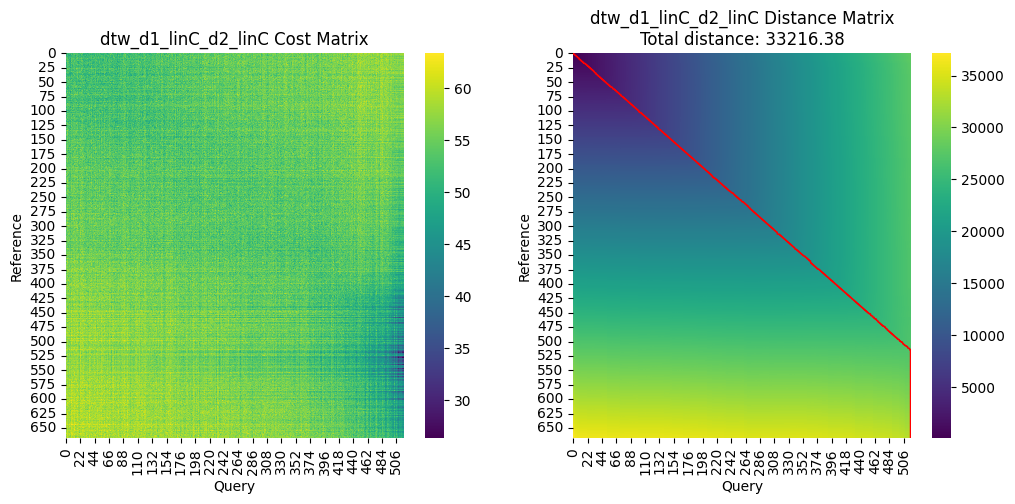

In [10]:
dynchro.tl.dynchronize(d1_linC, d2_linC, dtw_key="dtw_d1_linC_d2_linC", pseudotime_key="orig_pseudotime")

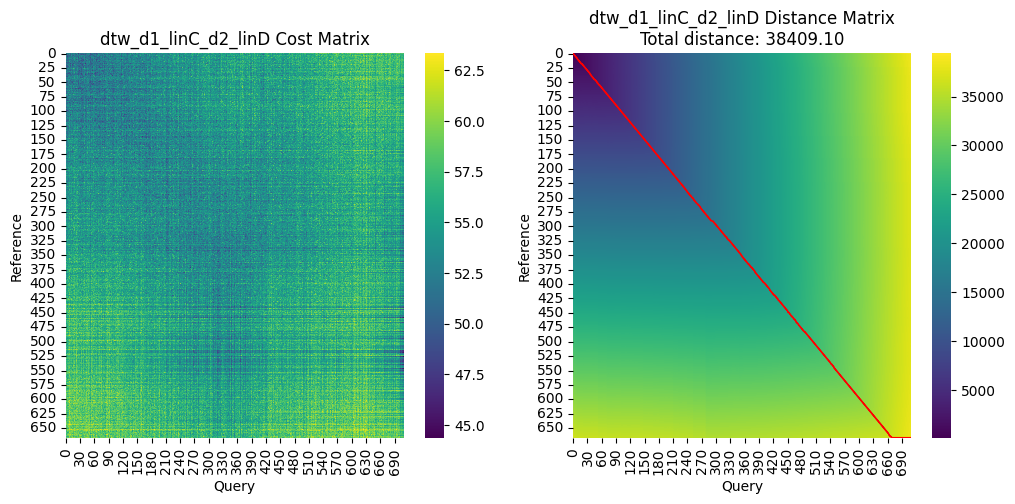

In [13]:
dynchro.tl.dynchronize(d1_linC, d2_linD, dtw_key="dtw_d1_linC_d2_linD", pseudotime_key="orig_pseudotime")

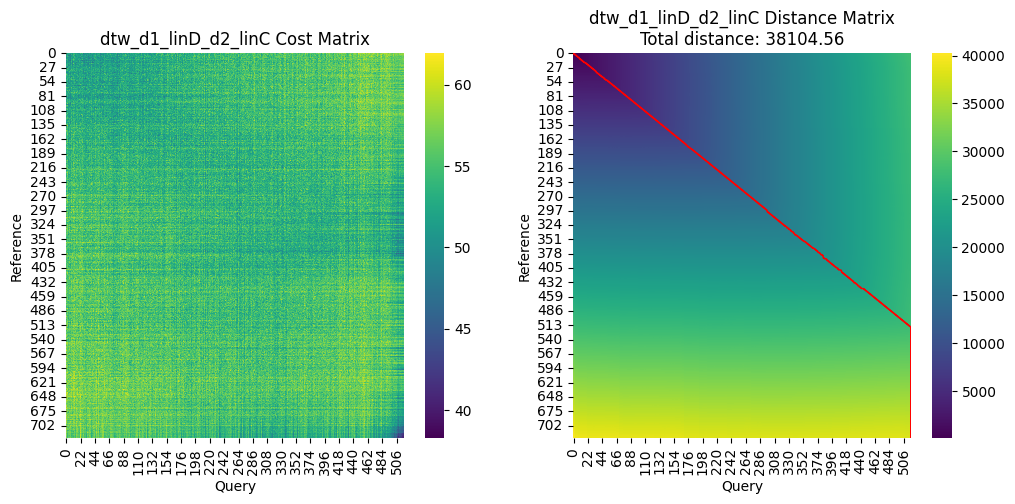

In [14]:
dynchro.tl.dynchronize(d1_linD, d2_linC, dtw_key="dtw_d1_linD_d2_linC", pseudotime_key="orig_pseudotime")

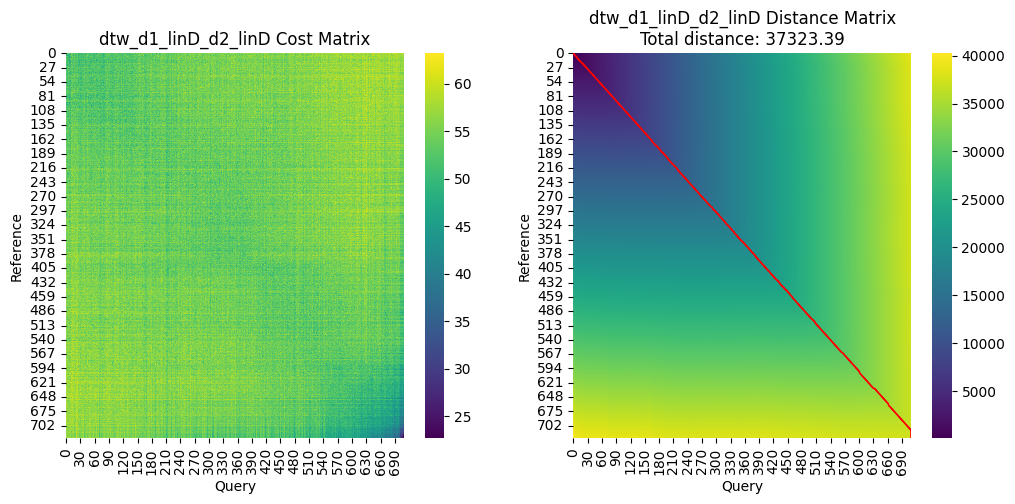

In [15]:
dynchro.tl.dynchronize(d1_linD, d2_linD, dtw_key="dtw_d1_linD_d2_linD", pseudotime_key="orig_pseudotime")

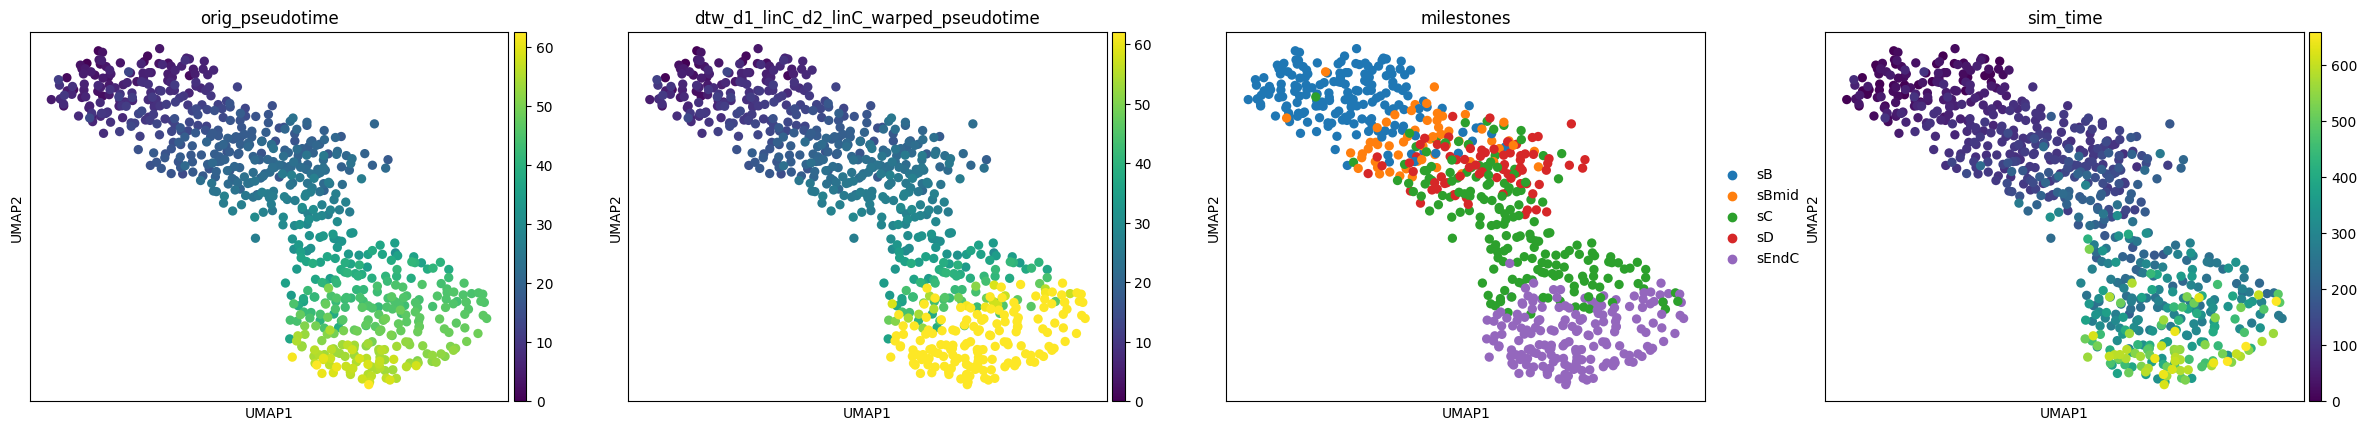

In [16]:
sc.pl.umap(d1_linC, color=["orig_pseudotime", "dtw_d1_linC_d2_linC_warped_pseudotime", "milestones", "sim_time"])

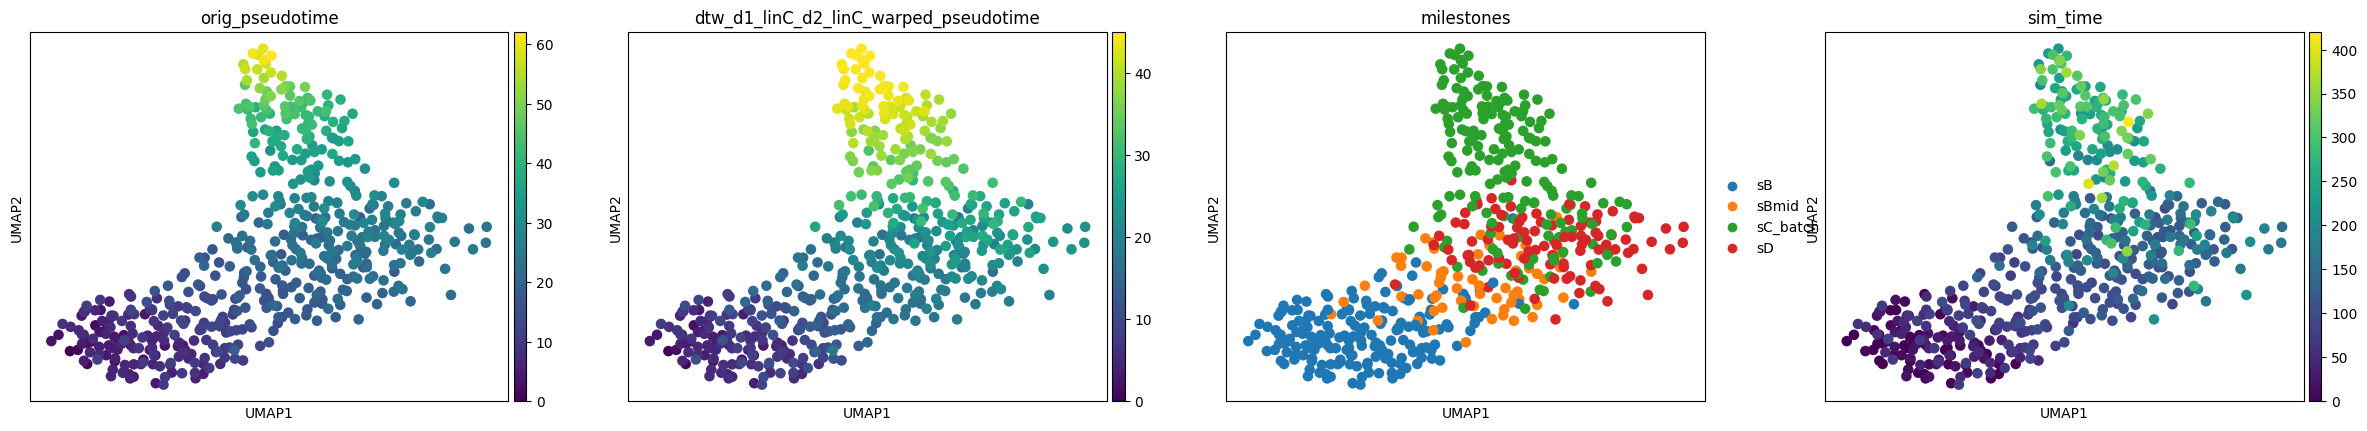

In [17]:
sc.pl.umap(d2_linC, color=["orig_pseudotime", "dtw_d1_linC_d2_linC_warped_pseudotime", "milestones", "sim_time"])

# 4. Compute metrics

In [18]:
linC = ad.concat([d1_linC, d2_linC], axis=0)
linD = ad.concat([d1_linD, d2_linD], axis=0)

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [19]:
endc_start = min(d1_linC[d1_linC.obs["milestones"] == "sEndC"].obs["orig_linC_pseudotime"])

min_pt = min(d1_linC.obs["orig_pseudotime"])
max_pt = max(d1_linC.obs["orig_pseudotime"])

endc_start_norm = (endc_start - min_pt) / (max_pt - min_pt)
endc_start_norm

0.5908188837727303

In [22]:
# Calculating the kde densities of lineage c, for each dataset and for both datasets together
# Saved to be used in the plotting script

bw = 0.1
pseudotimes =["orig_pseudotime", "dtw_d1_linC_d2_linC_warped_pseudotime"]
method = "dynchro"

res1_orig = dynchro.tl.get_kde_eval(d1_linC, pseudotimes[0], mode = "only_results", bandwidth = bw)
res1_after = dynchro.tl.get_kde_eval(d1_linC, pseudotimes[1], mode = "only_results", bandwidth = bw)

res2_orig = dynchro.tl.get_kde_eval(d2_linC, pseudotimes[0], mode = "only_results", bandwidth = bw)
res2_after = dynchro.tl.get_kde_eval(d2_linC, pseudotimes[1], mode = "only_results", bandwidth = bw)

both_orig = dynchro.tl.get_kde_eval(linC, pseudotimes[0], mode = "only_results", bandwidth = bw)
both_after = dynchro.tl.get_kde_eval(linC, pseudotimes[1], mode = "only_results", bandwidth = bw)

dump = {
    "d1": {
        "orig": res1_orig,
        "after": res1_after,
        "cutoff": endc_start_norm,
    },
    "d2": {
        "orig": res2_orig,
        "after": res2_after,
        "cutoff": endc_start_norm,
    },
    "both": {
        "orig": both_orig,
        "after": both_after,
        "cutoff": endc_start_norm,
    }
}
import pickle
pickle.dump(dump, open(f"data/{method}_dump.p", "wb"))

/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:19: UserWarning: Vector orig_pseudotime is not normalized between 0 and 1. Normalizing it now and storing as 'norm_orig_pseudotime'.
  warn(f"Vector {pseudotime_key} is not normalized between 0 and 1. Normalizing it now and storing as 'norm_{pseudotime_key}'.")
/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:19: UserWarning: Vector dtw_d1_linC_d2_linC_warped_pseudotime is not normalized between 0 and 1. Normalizing it now and storing as 'norm_dtw_d1_linC_d2_linC_warped_pseudotime'.
  warn(f"Vector {pseudotime_key} is not normalized between 0 and 1. Normalizing it now and storing as 'norm_{pseudotime_key}'.")
/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:19: UserWarning: Vector orig_pseudotime is not normalized between 0 and 1. Normalizing it now and storing as 'norm_orig_pseudotime'.
  warn(f"Vector {pseudotime_key} is not normalized between 0 and 1. Normalizing it now and storing as 'norm_{pseudotime_key}'.")
/home/louise/W